___

## xxx
#### DJ Dawkins, Nathan Deinlein, Joseph Lazarus, and Puri Rudick​

DS7333 QTW: Case Study 6
___

The goal for this case study is to build a classification model using a dense neural network to distinguish between a signal process which produces Higgs bosons and a background process which does not.

The goal is to maximize the accuracy and describe the decisions made while designing and building the network as well as determining when the model has sufficiently finished training. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# The file is 1.63GB, which is too big for Github
# Save the file locally and read in using the file's path

path = 'C:/Users/puri.rudick/Downloads/all_train.csv.gz'

df = pd.read_csv(path, compression='gzip', on_bad_lines='skip')

In [3]:
df.shape

(7000000, 29)

In [4]:
df.describe()

,# label,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f18,f19,f20,f21,f22,f23,f24,f25,f26,mass
count,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,...,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06
mean,5.001256e-01,1.612528e-02,4.770022e-04,2.686578e-05,1.056081e-02,-1.050026e-04,2.765919e-03,1.815953e-02,2.510948e-05,4.345870e-04,...,1.164789e-02,-1.127097e-04,7.686731e-05,2.909202e-04,1.228774e-02,9.778378e-03,5.269844e-03,-1.760961e-03,1.533136e-02,1.000107e+03
std,5.000000e-01,1.004417e+00,9.974864e-01,1.000080e+00,9.956003e-01,9.998670e-01,1.000957e+00,9.867746e-01,9.965867e-01,1.000007e+00,...,1.002725e+00,1.000038e+00,1.000033e+00,1.000170e+00,1.010477e+00,1.005418e+00,1.009990e+00,9.844511e-01,9.822799e-01,3.534255e+02
min,0.000000e+00,-1.960549e+00,-2.365355e+00,-1.732165e+00,-9.980274e+00,-1.732137e+00,-1.054221e+00,-3.034787e+00,-2.757853e+00,-1.732359e+00,...,-1.728284e+00,-2.281867e+00,-1.731758e+00,-5.736825e-01,-3.631608e+00,-4.729473e+00,-2.062223e+01,-3.452634e+00,-2.632761e+00,5.000000e+02
25%,0.000000e+00,-7.288206e-01,-7.332548e-01,-8.656704e-01,-6.092291e-01,-8.658025e-01,-1.054221e+00,-7.566092e-01,-7.014146e-01,-8.656543e-01,...,-7.423630e-01,-7.206846e-01,-8.656855e-01,-5.736825e-01,-5.417942e-01,-5.115522e-01,-3.543870e-01,-6.925097e-01,-7.943804e-01,7.500000e+02
50%,1.000000e+00,-3.930319e-02,8.523957e-04,3.199154e-04,1.963316e-02,-5.070131e-04,-5.983562e-03,-1.499527e-01,-1.067553e-04,1.384781e-03,...,-8.992496e-02,-6.735953e-05,-4.424527e-04,-5.736825e-01,-1.602760e-01,-3.144032e-01,-3.265228e-01,-3.570301e-01,-8.828640e-02,1.000000e+03
75%,1.000000e+00,6.900799e-01,7.347832e-01,8.659464e-01,6.798818e-01,8.657646e-01,8.504885e-01,7.686690e-01,7.013194e-01,8.665976e-01,...,6.423185e-01,7.204921e-01,8.659566e-01,-5.736825e-01,4.812194e-01,1.634892e-01,-2.337671e-01,4.753128e-01,7.610846e-01,1.250000e+03
max,1.000000e+00,4.378282e+00,2.365287e+00,1.732370e+00,4.148023e+00,1.731978e+00,4.482618e+00,3.720345e+00,2.758590e+00,1.731450e+00,...,5.866367e+00,2.282217e+00,1.732740e+00,1.743123e+00,7.293420e+00,9.333287e+00,1.499064e+01,5.277313e+00,4.444690e+00,1.500000e+03


Balance dataset

In [5]:
print(df.groupby(['# label'])['# label'].count())

# label
0.0    3499121
1.0    3500879
Name: # label, dtype: int64


In [6]:
# Count missing values
df_na = pd.DataFrame(df.isna().sum())
df_na.rename(columns={df_na.columns[0]: 'count'}, inplace = True)

df_na = df_na[df_na['count'] != 0]
df_na['percent_missing'] = df_na['count']/df.shape[0]
df_na = df_na.sort_values('count', ascending=False)

df_na

,count,percent_missing


In [7]:
# Check for duplicate rows
print('Duplicate rows: ', df.duplicated(keep='first').sum())

Duplicate rows:  0


f6 and f26 have a little different distributions between label 0 and 1. </br>
f24 has 0 as dominant values with some outliers.

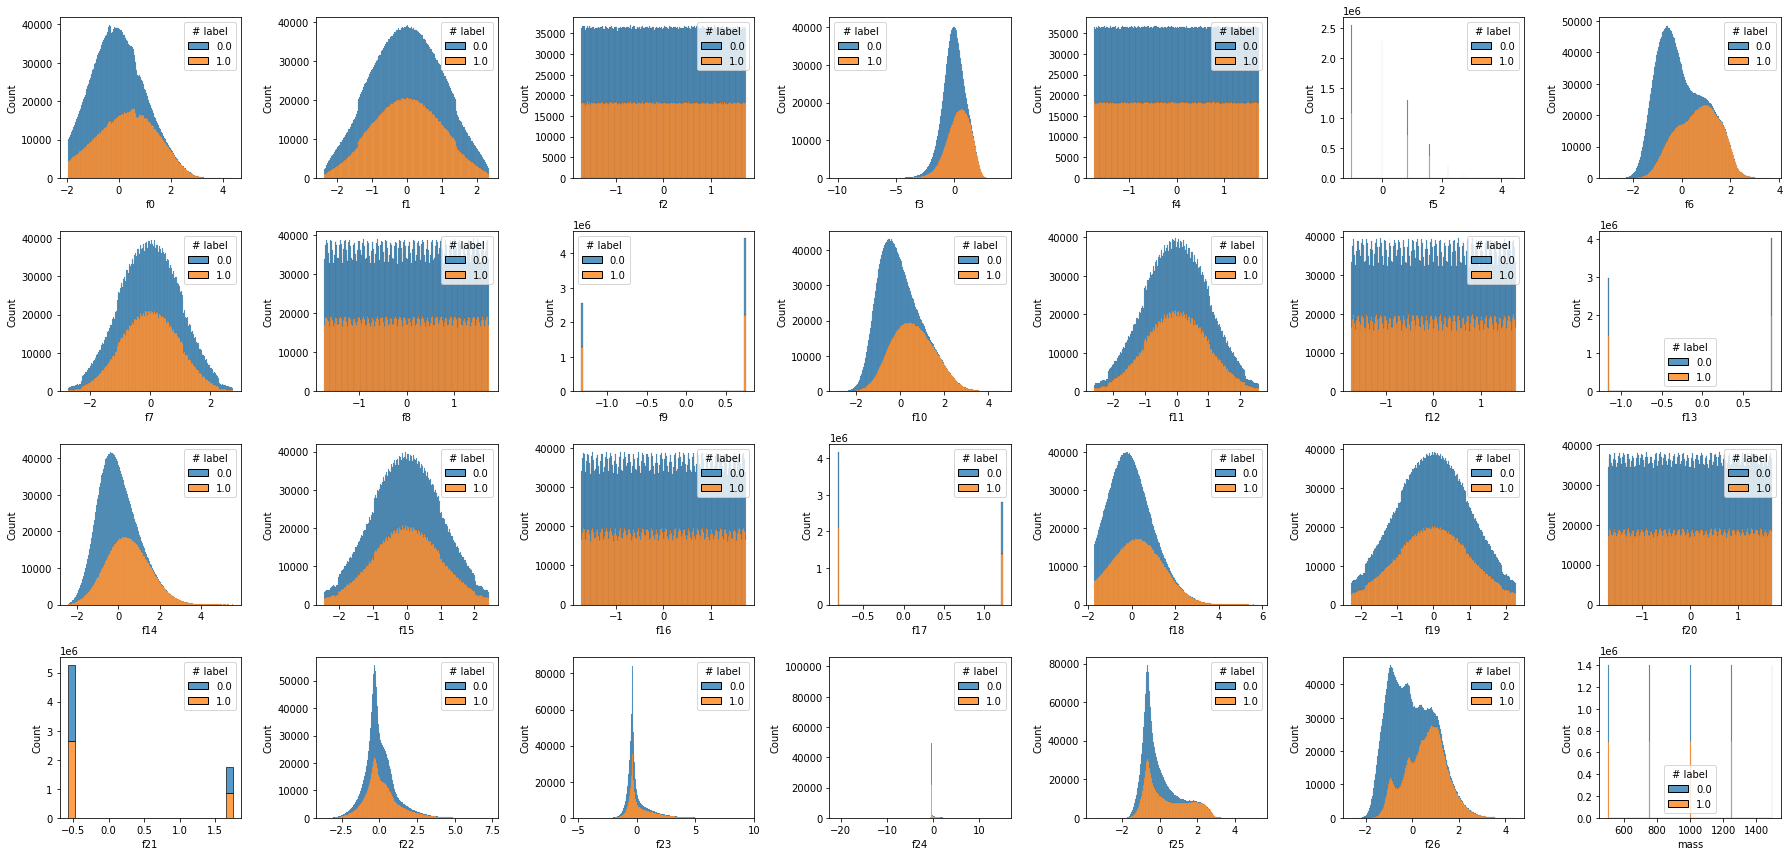

In [8]:
df_features = df.copy()
df_features.drop(["# label"], axis=1, inplace=True)

fig,axs = plt.subplots(4,7, figsize = (25,12))
h, v = 0, 0
for i in df_features.columns:
    sns.histplot(data=df, x=i, hue='# label', multiple='stack', ax=axs[h, v])
    if v == 6:
        h += 1
        v = -1
    v += 1
fig.tight_layout()

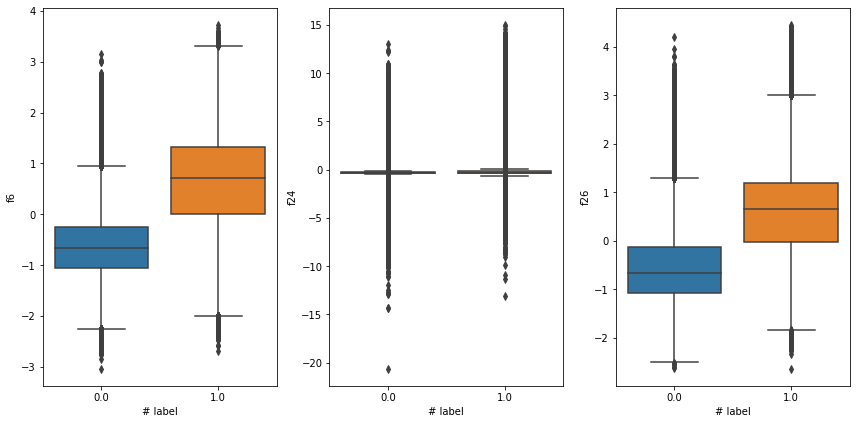

In [9]:
fig,axs = plt.subplots(1, 3, figsize = (12, 6))

sns.boxplot(data=df, x='# label', y='f6', ax=axs[0])
sns.boxplot(data=df, x='# label', y='f24', ax=axs[1])
sns.boxplot(data=df, x='# label', y='f26', ax=axs[2])

fig.tight_layout()

Overall, nothing really strongly correlates to each other.  Correlation value is within only (-.3, .3)

<AxesSubplot:>

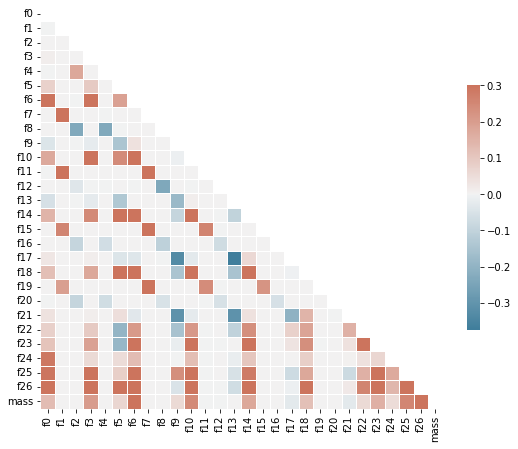

In [10]:
# Get correlation
corr = df_features.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Split dataset 

In [11]:
from sklearn.model_selection import train_test_split

model_data = df.copy()

feature_data = model_data.copy()
feature_data.drop(["# label"], axis=1, inplace=True)

target_data = model_data['# label']

# Splitted train and test dataset
X_train, X_test, y_train, y_test = train_test_split(feature_data,target_data,test_size=0.10,random_state=0)

print("Size of modeling set (to be CV split): ", X_train.shape)
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))
print("Size of hold back validation set: ", X_test.shape)
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))

Size of modeling set (to be CV split):  (6300000, 28)
1.0    3150462
0.0    3149538
Name: # label, dtype: int64
1.0    0.500073
0.0    0.499927
Name: # label, dtype: float64
Size of hold back validation set:  (700000, 28)
1.0    350417
0.0    349583
Name: # label, dtype: int64
1.0    0.500596
0.0    0.499404
Name: # label, dtype: float64


In [12]:
#Scale new predictor matrix
from sklearn.preprocessing import StandardScaler

scl_obj = StandardScaler()
scl_obj.fit(X_train)
X_train_ = scl_obj.transform(X_train)

scl_obj.fit(X_test)
X_test_ = scl_obj.transform(X_test)

In [13]:
# TensorFlow and tf.keras
import tensorflow as tf
tf.random.set_seed(1234)

print(tf.__version__)

2.9.1


In [14]:
import keras.backend as K

# define metrics
def Recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def Precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1(y_true, y_pred):
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Initialize the constructor
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation = 'relu', input_shape=(X_train_.shape[1], )),     # Add an input layer 
    tf.keras.layers.Dense(8, activation = 'relu'),                         # Add one hidden layer 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                       # Add an output layer 
])  

model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', F1])
                   
model1_ = model1.fit(X_train_, y_train, validation_split=0.1, epochs=10, batch_size=10000, verbose=0)
print(model1.evaluate(X_test_, y_test, batch_size=10000))
# print(model1.summary())

In [ ]:
# Initialize the constructor
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation = 'relu', input_shape=(X_train_.shape[1], )),     # Add an input layer 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation = 'relu'),                         # Add one hidden layer 
    tf.keras.layers.Dense(1, activation='sigmoid')                       # Add an output layer 
])  

model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', F1])
                   
model2_ = model2.fit(X_train_, y_train, validation_split=0.1, epochs=10, batch_size=10000, verbose=0)
print(model2.evaluate(X_test_, y_test, batch_size=10000))
# print(model2.summary())

In [ ]:
# plot
metrics = [k for k in model1_.history.keys() if ("loss" not in k) and ("val" not in k)]    
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
       
## model1_    
ax[0].set(title="Training")    
ax11 = ax[0].twinx()    
ax[0].plot(model1_.history['loss'], color='black')
ax[0].set_xlabel('Epochs')    
ax[0].set_ylabel('Loss', color='black')    
for metric in metrics:        
    ax11.plot(model1_.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')    
ax11.legend()
        
# validation    
ax[1].set(title="Validation")    
ax22 = ax[1].twinx()    
ax[1].plot(model1_.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')    
ax[1].set_ylabel('Loss', color='black')    
for metric in metrics:          
    ax22.plot(model1_.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")    
plt.show()

---
## HParams

In [ ]:
# Random Forest - Using Full_df
sample_data = df.copy()

# 0.1% random sampling from original dataset
sample_data = sample_data.sample(frac=0.001)

sample_feature_data = sample_data.copy()
sample_feature_data.drop(["# label"], axis=1, inplace=True)

sample_target_data = sample_data['# label']

# Splitted train and test dataset
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(sample_feature_data,sample_target_data,test_size=0.10,random_state=0)

print("Size of modeling set (to be CV split): ", X_train_sample.shape)
print(y_train_sample.value_counts())
print(y_train_sample.value_counts(normalize=True))
print("Size of hold back validation set: ", X_test_sample.shape)
print(y_test_sample.value_counts())
print(y_test_sample.value_counts(normalize=True))

In [ ]:
scl_obj = StandardScaler()
scl_obj.fit(X_train)
X_train_sample_ = scl_obj.transform(X_train_sample)

scl_obj.fit(X_test)
X_test_sample_ = scl_obj.transform(X_test_sample)

In [ ]:
from tensorboard.plugins.hparams import api as hp

HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([15]))
HP_NUM_UNITS2 = hp.HParam('num_units2', hp.Discrete([8]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam']))  #['adam', 'sgd', 'RMSprop']
HP_L2 = hp.HParam('l2 regularizer', hp.RealInterval(.001, .01))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_NUM_UNITS2, HP_L2, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [ ]:
def train_test_model(hparams):
  model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation='relu', input_shape=(X_train_sample_.shape[1], )),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS2], kernel_regularizer=tf.keras.regularizers.l2(0.001), activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
  ])
  
  model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='binary_crossentropy',
      metrics=['accuracy'],
  )

  model.fit(X_train_sample_, y_train_sample, epochs=10, verbose=0) # Run with 1 epoch to speed things up for demo purposes
  _, accuracy = model.evaluate(X_test_sample_, y_test_sample, verbose=0)
  return accuracy

def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)
    return accuracy

In [ ]:
session_num = 0
search_dict = {}

for num_units in HP_NUM_UNITS.domain.values:
  for num_units2 in HP_NUM_UNITS2.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
      for l2 in (HP_L2.domain.min_value, HP_L2.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
          hparams = {
              HP_NUM_UNITS: num_units,
              HP_NUM_UNITS2: num_units2,
              HP_DROPOUT: dropout_rate,
              HP_L2: l2,
              HP_OPTIMIZER: optimizer,
          }
          run_name = "run-%d" % session_num
          # print('--- Starting trial: %s' % run_name)
          # print({h.name: hparams[h] for h in hparams})
          h = {h.name: hparams[h] for h in hparams}
          a = run('logs/hparam_tuning/' + run_name, hparams)
          search_dict.update({str(h):a})
          session_num += 1

highest_acc = max(search_dict, key=search_dict.get)
print('From our minimal search,')
print('The parameters that give the highest accuracy are:', highest_acc, '\nWith the model accuracy from the test dataset of', search_dict[highest_acc])

In [ ]:
%tensorboard --logdir logs/hparam_tuning

In [ ]:
# Initialize the constructor
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation = 'relu', input_shape=(X_train_.shape[1], )),     # Add an input layer 
    tf.keras.layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation = 'relu'),                         # Add one hidden layer 
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                       # Add an output layer 
])  

model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', F1])
                   
model1_ = model1.fit(X_train_, y_train, validation_split=0.1, epochs=10, batch_size=10000, verbose=0)
print(model1.evaluate(X_test_, y_test, batch_size=10000))
# print(model1.summary())

In [ ]:
# plot
metrics = [k for k in model1_.history.keys() if ("loss" not in k) and ("val" not in k)]    
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
       
## model1_    
ax[0].set(title="Training")    
ax11 = ax[0].twinx()    
ax[0].plot(model1_.history['loss'], color='black')
ax[0].set_xlabel('Epochs')    
ax[0].set_ylabel('Loss', color='black')    
for metric in metrics:        
    ax11.plot(model1_.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')    
ax11.legend()
        
# validation    
ax[1].set(title="Validation")    
ax22 = ax[1].twinx()    
ax[1].plot(model1_.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')    
ax[1].set_ylabel('Loss', color='black')    
for metric in metrics:          
    ax22.plot(model1_.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")    
plt.show()